# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10. 

### The code in this notebook depends on the environment it is running.

In [4]:
import sys
colab = True if 'google.colab' in sys.modules else False
colab

False

In [5]:
import datetime
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from tensorflow import keras
from tqdm import tqdm_notebook
import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
from tensorboard.plugins import projector
from tensorboard import summary
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import accuracy_score

if colab:
    from keras.datasets import cifar10
    tensorboard_path = './content/logs'
    # Configure Keras to use the GPU


else:
    tensorboard_path = './Keras_lecture_3_HW/logs'
from sklearn.model_selection import train_test_split


### Initializing tensorboard

In [6]:
# Clear any logs from previous runs
!rm -rf {tensorboard_path}
# Load the TensorBoard notebook extension
%load_ext tensorboard


### Check the GPU availability

In [7]:
# Configure TensorFlow to use the GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    !nvidia-smi
physical_devices

[]

In [8]:
import gc
def clean_memory():
    '''Clear memory from garbage collection and TensorFlow session'''
    tf.keras.backend.clear_session()
    # Reset TensorFlow graph
    tf.compat.v1.reset_default_graph()
    # Garbage collection
    gc.collect()
clean_memory()

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [9]:
if colab:
    # Loading data from the web (https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

    class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

    print (X_train.shape,y_train.shape)
    print (X_val.shape,y_val.shape)
else:
    # emulate the data loading printouts
    print('Downloading data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
    print('170498071/170498071 [==============================] - 250s 1us/step')
    print('(40000, 32, 32, 3) (40000, 1)')
    print('(10000, 32, 32, 3) (10000, 1)')

170498071/170498071 [==============================] - 250s 1us/step
(40000, 32, 32, 3) (40000, 1)
(10000, 32, 32, 3) (10000, 1)


In [10]:
if not colab:
    from typing import Tuple
    from pathlib import Path
    
    # Loading data from local drive  
    cifar10_dir = Path('/Users/velo1/SynologyDrive/GIT_syno/data/CNN/cifar-10-batches-py')

    def load_cifar10_data(path: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        '''Load CIFAR10 data from `path`'''

        # Load train data
        X_train_batches = []
        y_train_batches = []
        # we have 5 batches 'cifar-10-batches-py' folder named data_batch_1, data_batch_2, etc.
        for i in range(1, 6):
            with open(path + '/data_batch_' + str(i), 'rb') as f:
                # load data from the file
                data_batch = pickle.load(f, encoding='bytes')
            # each batch is a dictionary with keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
            # b indicates bytes literals instead of regular Unicode strings.
            X_train_batches.append(data_batch[b'data'])
            y_train_batches.append(data_batch[b'labels'])

        # X_train_batches is a list of 5 arrays, each array has 10000 rows and 3072 columns
        # then we concatenate them into one array
        # and reshape it to (num, img_width, img_height, channels)
        X_train = revert_dim_to_image(np.concatenate(X_train_batches))
        # get labels
        y_train = np.concatenate(y_train_batches)

        # Load test data
        with open(path + '/test_batch', 'rb') as f:
            # load data from the file
            # test_batch is a dictionary with keys: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
            test_batch = pickle.load(f, encoding='bytes')

        # convert dictionary to numpy array
        # and reshape it to (num, img_width, img_height, channels)
        X_test = revert_dim_to_image(np.array(test_batch[b'data']))
        # get labels
        y_test = np.array(test_batch[b'labels'])

        return X_train, y_train, X_test, y_test

    def revert_dim_to_image(tensor: np.ndarray) -> np.ndarray:
        '''Revert a tensor shape from (num, 3072) to (num, img_width, img_height, channels)'''
        return tensor.reshape(-1, 3, 32, 32).transpose([0, 2, 3, 1])
    
    X_train, y_train, X_test, y_test = load_cifar10_data(str(cifar10_dir) )
    print ('Original dataset  :', X_train.shape,y_train.shape, X_test.shape, y_test.shape)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)



print ('Train + Test set  :',X_train.shape,y_train.shape, X_val.shape, y_val.shape)

Original dataset  : (50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)
Train + Test set  : (40000, 32, 32, 3) (40000,) (10000, 32, 32, 3) (10000,)


### Loading CIFAR-10 classes

In [11]:
if not colab:
    def load_cifar10_meta(path):
        with open(path, 'rb') as file:
            meta = pickle.load(file, encoding='bytes')
        return meta

    meta = load_cifar10_meta(str( cifar10_dir / 'batches.meta') )
    print(meta.keys())
    print(meta[b'label_names'])
    class_names = np.array([x.decode('utf-8') for x in meta[b'label_names']])

class_names

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])
[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']


array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

### Check the dataset

Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

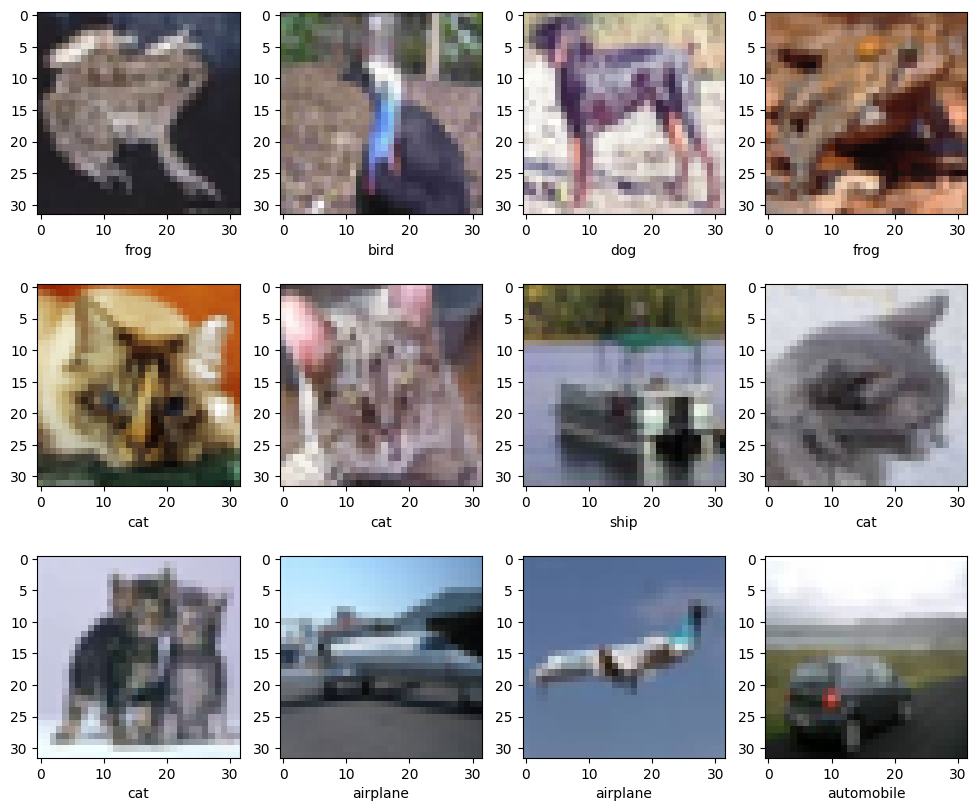

In [12]:
plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)

    image = X_train[i]
    if colab:
        plt.xlabel(class_names[y_train[i][0]])
    else:
        plt.xlabel(class_names[y_train[i]])
    plt.imshow(image)

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [13]:
X_train = X_train / 255.
X_val = X_val / 255.
X_test = X_test / 255.

Исполните код ниже для проверки, что все выполнено корректно.

In [14]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [15]:
print('Train  set:', y_train.shape, X_train.shape)
print('Val    set:', y_val.shape, X_val.shape)
print('Test   set:', y_test.shape, X_test.shape)


Train  set: (40000,) (40000, 32, 32, 3)
Val    set: (10000,) (10000, 32, 32, 3)
Test   set: (10000,) (10000, 32, 32, 3)


In [16]:
simple_model = keras.models.Sequential(
    [
    keras.layers.Flatten(),                      # (N,C,H,W) --> (N, C*H*W)
    keras.layers.Dense(32, activation="relu"),                                    
    # keras.layers.Dropout(0.3),                      
    keras.layers.Dense(32, activation="relu"), 
    # keras.layers.Dropout(0.3),                     
    keras.layers.Dense(10, activation='softmax'),
    ]
    )

simple_model.compile(optimizer= keras.optimizers.Adam(learning_rate=3e-4),
            #   'adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=keras.metrics.SparseCategoricalAccuracy())
simple_model.build(input_shape=(None, 32, 32, 3))
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 32)                98336     
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 99,722
Trainable params: 99,722
Non-trainable params: 0
_________________________________________________________________


In [17]:
dummy_pred = simple_model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 277ms/step
Успех!


In [18]:
# Create a summary writer for logging
if colab:
    log_dir = '/content/logs/fit' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # Specify the log directory
else:   
    log_dir = 'Keras_lecture_3_HW/logs/fit' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # Specify the log directory
summary_writer = tf.summary.create_file_writer(log_dir)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [19]:
clean_memory()

In [20]:
def plot_results(df_results: pd.DataFrame, model_name: str)->None:
    '''Plot the loss and accuracy values from a dataframe of results.
    '''
    fig = go.Figure()

    # Draw main line
    fig.add_trace(go.Scatter(x=df_results.index, y=df_results.loss, mode='lines', fill="none", name="Train loss", line=dict( width=1 )))
    fig.add_trace(go.Scatter(x=df_results.index, y=df_results.val_loss, mode='lines', fill="none", name="Val loss", line=dict( width=3 )))

    # Create a second y-axis for accuracy and val_accuracy
    fig.update_layout(yaxis=dict(title='Loss'),
                    yaxis2=dict(title='Accuracy', overlaying='y', side='right'))

    # Draw lines for accuracy and val_accuracy using the second y-axis
    fig.add_trace(go.Scatter(x=df_results.index, y=df_results.accuracy, mode='lines', fill="none", name="Train accuracy",
                            yaxis='y2', line=dict( width=1 )))
    fig.add_trace(go.Scatter(x=df_results.index, y=df_results.val_accuracy, mode='lines', fill="none", name="Val accuracy",
                            yaxis='y2', line=dict( width=3 )))

    # Add title and x-axis title
    fig.update_layout(title=f'Training Results of {model_name}',
                    xaxis=dict(title='Epochs'))

    fig.show()


In [21]:
def train_model(model, X_train, y_train, augmented_data=None, X_val=None, y_val=None, epochs=100, patience=5, threshold=1e-4, verbose=1):
    '''Train a model and update the metrics plot after each epoch.
    '''
    # Create empty lists to store metrics values
    results = {}
    best_val_loss = float('inf')

    # Train the model and update the metrics plot after each epoch
    for epoch in range(epochs):
        if augmented_data is not None:
            history = model.fit(
                augmented_data,
                validation_data=(X_val, y_val), 
                epochs=1, 
                verbose=1, 
                callbacks=[tensorboard_callback]
            )
        else:
            history = model.fit(
                X_train,
                y_train,
                validation_data=(X_val, y_val), 
                epochs=1, 
                verbose=1, 
                callbacks=[tensorboard_callback]
            )
        
        
        # Update metrics dictionary with the values for the current epoch
        results[epoch] = {
            'loss': history.history['loss'][0], 
            'val_loss': history.history['val_loss'][0], 
            'accuracy': history.history['sparse_categorical_accuracy'][0], 
            'val_accuracy': history.history['val_sparse_categorical_accuracy'][0]
        }
        
        # Check if validation loss has improved
        if history.history['val_loss'][0] < best_val_loss - threshold:
            best_val_loss = history.history['val_loss'][0]
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after epoch {epoch}')
                break
    print('Test:', model.evaluate(X_test, y_test, verbose=0)[1])
    print('Val: ', model.evaluate(X_val, y_val, verbose=0)[1])    

    return results


In [ ]:
results_simple = train_model(simple_model, X_train, y_train, X_val=X_val, y_val=y_val, epochs=100, patience=3, threshold=1e-3, verbose=1)
df_results = pd.DataFrame(results_simple).T
df_results.index.name = 'Epoch'
plot_results(df_results, 'Simple model')


1250/1250 [==============================] - 4s 3ms/step - loss: 1.5649 - sparse_categorical_accuracy: 0.4406 - val_loss: 1.6179 - val_sparse_categorical_accuracy: 0.4277
Early stopping after epoch 20
Test: 0.43059998750686646
Val:  0.427700012922287


### Why validation metrics might be higher than train metrics?  
[Higher validation accuracy, than training accurracy using Tensorflow and Keras](https://stackoverflow.com/questions/43979449/higher-validation-accuracy-than-training-accurracy-using-tensorflow-and-keras)

* **Dropout:** Dropout is a regularization technique commonly used in neural networks to prevent overfitting. It works by randomly setting a fraction of the input units to 0 at each update during training. This means that during training, some neurons are "dropped out" or deactivated, leading to a reduced model capacity.

* **Training Phase:** During the training phase, when Dropout is applied, the model is exposed to a noisy version of the data. By randomly deactivating some neurons, Dropout forces the model to learn more robust and generalizable representations. It prevents the model from relying too heavily on specific features or combinations of features.

* **Testing Phase:** During the testing phase or evaluation, Dropout is typically turned off. All the neurons are used, and there is no dropout applied. This is done to obtain more reliable and accurate predictions because using all the features provides a more complete and comprehensive representation of the input data.

* **Model Robustness:** Dropout helps to create a more robust model by reducing the co-adaptation of neurons. It encourages each neuron to learn useful features independently, without relying on other specific neurons. This results in a more diverse set of features being learned by the model, which can improve its generalization ability.

* **Higher Validation Metrics:** Due to the regularization effect of Dropout, the model can have better generalization performance during testing. It can perform well on unseen data because it has learned to be less dependent on specific features or combinations of features. This can lead to higher validation metrics (such as accuracy) compared to the training metrics, where the model may have learned to overfit to the training data.

In summary, Dropout introduces noise and regularization during training, forcing the model to learn more robust representations. During testing, Dropout is turned off, allowing the model to use all features and make more accurate predictions. This difference in behavior between training and testing phases can result in higher validation metrics compared to train metrics.





### Let's add dropout layers to check if validation metrics during training are actually higher.

In [ ]:
simple_model_with_dropouts = keras.models.Sequential(
    [
    keras.layers.Flatten(),                      # (N,C,H,W) --> (N, C*H*W)
    keras.layers.Dense(32, activation="relu"),                                    
    keras.layers.Dropout(0.3),                      
    keras.layers.Dense(32, activation="relu"), 
    keras.layers.Dropout(0.3),                     
    keras.layers.Dense(10, activation='softmax'),
    ]
    )

simple_model_with_dropouts.compile(optimizer= keras.optimizers.Adam(learning_rate=3e-4),
            #   'adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=keras.metrics.SparseCategoricalAccuracy())
# simple_model_with_dropouts.build(input_shape=(None, 32, 32, 3))
# simple_model_with_dropouts.summary()

In [ ]:
results_model_with_dropouts= train_model(simple_model_with_dropouts, X_train, y_train, X_val=X_val, y_val=y_val, epochs=100, patience=3, threshold=1e-3, verbose=1)
df_results = pd.DataFrame(results_model_with_dropouts).T
df_results.index.name = 'Epoch'
plot_results(df_results, 'Simple model with dropout layers')

1250/1250 [==============================] - 5s 4ms/step - loss: 2.0416 - sparse_categorical_accuracy: 0.2227 - val_loss: 1.9956 - val_sparse_categorical_accuracy: 0.2485
Early stopping after epoch 24
Test: 0.24240000545978546
Val:  0.2485000044107437


As you can see, the model with dropout layers is more robust to overfitting.  
The validation loss is lower than the training loss, which is not ideal, but the difference is small.  
And the validation accuracy is higher than the training accuracy, which is great.  
Such behavior is not uncommon when using dropout layers.

## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
# y_train, y_val = (keras.utils.to_categorical(y) for y in (y_train, y_val))

### Model based on Convolution layers with dropout layers

In [ ]:
cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    # keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)), 
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
cnn_model.compile(optimizer= keras.optimizers.Adam(learning_rate=3e-4),
              # from_logits=False as we use softmax activation
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=keras.metrics.SparseCategoricalAccuracy())
cnn_model.build(input_shape=(None, 32, 32, 3))
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [ ]:
results_cnn = train_model(cnn_model, X_train, y_train, X_val=X_val, y_val=y_val, epochs=100, patience=3, threshold=1e-3, verbose=1)
df_results = pd.DataFrame(results_cnn).T
df_results.index.name = 'Epoch'
plot_results(df_results, 'Model with convolutions and dropout layers')
    

1250/1250 [==============================] - 174s 139ms/step - loss: 0.2964 - sparse_categorical_accuracy: 0.8943 - val_loss: 0.6888 - val_sparse_categorical_accuracy: 0.7889
Early stopping after epoch 18
Test: 0.7847999930381775
Val:  0.7889000177383423


In [ ]:
# %tensorboard --logdir {tensorboard_path}

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
y_pred = cnn_model.predict(X_test)
# -1 means 
# find the index of the maximum value for each row in y_pred
test_acc = accuracy_score(y_test, y_pred.argmax(-1) )
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 3s 10ms/step

 Test_acc = 0.7848
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
pocket_model = keras.models.Sequential([

    keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)), 
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
pocket_model.compile(optimizer= keras.optimizers.Adam(learning_rate=3e-4),
              # from_logits=False as we use softmax activation
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=keras.metrics.SparseCategoricalAccuracy())
# pocket_model.build(input_shape=(None, 32, 32, 3))
# pocket_model.summary()

In [ ]:
results_pocket_model = train_model(pocket_model, X_train, y_train, X_val=X_val, y_val=y_val, epochs=100, patience=3, threshold=1e-2, verbose=1)
df_results = pd.DataFrame(results_pocket_model).T
df_results.index.name = 'Epoch'
plot_results(df_results, '"Pocket" model')

1250/1250 [==============================] - 10s 8ms/step - loss: 0.8807 - sparse_categorical_accuracy: 0.6962 - val_loss: 1.1231 - val_sparse_categorical_accuracy: 0.6158
Early stopping after epoch 16
Test: 0.6115000247955322
Val:  0.6158000230789185


Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
y_pred = pocket_model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred.argmax(-1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 1s 2ms/step

 Test_acc = 0.6115
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций. 

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    '''Class for evaluating multiple models with multiple optimizers'''
    def __init__(self, 
                 models, 
                 optimizers='adam', 
                 loss='SparseCategoricalCrossentropy',
                 metrics='SparseCategoricalAccuracy'):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''

        if not isinstance(models, dict):
            # if models is not a dict, then we assume that it is a single model
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            # if optimizers is not a dict, then we assume that it is a single optimizer
            optimizers = {str(optimizers.__class__): optimizers}
        
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()],
                          )
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
            
    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=64):
        '''Fit all models with all optimizers'''
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizers in self:
            model.fit(X, y, validation_data=validation_data or None, 
                      epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, 
                      callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir=tensorboard_path + f'/{model_name}_{optimizer_name}')])
            
    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=64):
        '''Add data augmentation'''
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in self:
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir=tensorboard_path + f'/{model_name}_{optimizer_name}')])
        
    def evaluate(self, X, y, metric):
        '''Evaluate all models with all optimizers'''
        for model_name, model, optimizer_name, _ in self:
            y_pred = model.predict(X)
            print(f'Final score of {model_name}_{optimizer_name} is {metric(y_test, y_pred.argmax(-1))}')

In [ ]:
# !rm -rf {tensorboard_path}

In [ ]:
optimizers = {
            'adam': keras.optimizers.Adam(learning_rate=3e-4),            
            'sgd': keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9),
            'rmsprop': keras.optimizers.RMSprop(learning_rate=3e-4, momentum=0.9),
            'adagrad': keras.optimizers.Adagrad(learning_rate=3e-4),
}
evaluator = Evaluator({'pocket':pocket_model}, optimizers=optimizers )
# evaluator

In [ ]:
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val), max_epochs=5, verbose=1, batch_size=1024)


Epoch 1/5
40/40 [==============================] - 5s 111ms/step - loss: 2.1638 - sparse_categorical_accuracy: 0.2248 - val_loss: 2.0106 - val_sparse_categorical_accuracy: 0.2995
Epoch 2/5
40/40 [==============================] - 4s 93ms/step - loss: 1.9150 - sparse_categorical_accuracy: 0.3398 - val_loss: 1.8564 - val_sparse_categorical_accuracy: 0.3605
Epoch 3/5
40/40 [==============================] - 4s 94ms/step - loss: 1.8102 - sparse_categorical_accuracy: 0.3801 - val_loss: 1.7822 - val_sparse_categorical_accuracy: 0.3759
Epoch 4/5
40/40 [==============================] - 4s 91ms/step - loss: 1.7474 - sparse_categorical_accuracy: 0.4012 - val_loss: 1.7328 - val_sparse_categorical_accuracy: 0.4036
Epoch 5/5
40/40 [==============================] - 4s 91ms/step - loss: 1.7035 - sparse_categorical_accuracy: 0.4171 - val_loss: 1.6990 - val_sparse_categorical_accuracy: 0.4192
Epoch 1/5
40/40 [==============================] - 4s 98ms/step - loss: 2.3585 - sparse_categorical_accuracy:

In [ ]:
evaluator.evaluate(X_test, y_test, accuracy_score)

313/313 [==============================] - 1s 2ms/step
Final score of pocket_adam is 0.4196
313/313 [==============================] - 1s 2ms/step
Final score of pocket_sgd is 0.1956
313/313 [==============================] - 1s 2ms/step
Final score of pocket_rmsprop is 0.5007
313/313 [==============================] - 1s 2ms/step
Final score of pocket_adagrad is 0.1293


Прокомментируйте полученные результаты.

#### Look, the best results have been achieved with the `rmsprop` optimizer.  
The `Adam` optimizer has performed slightly worse.  
Then follows the `sgd` and `Adagrad` optimizers. 

In [ ]:
# !tensorboard --logdir {tensorboard_path}

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [22]:
best_model_rmsprop = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Dropout(0.25),    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Dropout(0.25),    
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),  

    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.Dropout(0.25),    
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),     

    keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    keras.layers.Dropout(0.25),    
    keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),        
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
best_model_rmsprop.compile(optimizer=keras.optimizers.RMSprop(learning_rate=3e-4),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=[keras.metrics.SparseCategoricalAccuracy()])
best_model_rmsprop.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

In [26]:
clean_memory()

In [23]:
datagen = ImageDataGenerator(
    rotation_range=20,       
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    horizontal_flip=True     
)
augmented_data = datagen.flow(X_train, y_train, batch_size= 32)

results_best_model = train_model(best_model_rmsprop, X_train, y_train,augmented_data=augmented_data,
                                 X_val=X_val, y_val=y_val, epochs=100, patience=10, threshold=1e-3, verbose=1)
df_results = pd.DataFrame(results_best_model).T
df_results.index.name = 'Epoch'
plot_results(df_results, '"Best" model. RMSprop')


2023-06-04 21:20:41.277803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 669s 533ms/step - loss: 2.1114 - sparse_categorical_accuracy: 0.2269 - val_loss: 2.2147 - val_sparse_categorical_accuracy: 0.2246


2023-06-04 21:31:50.361975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 502s 402ms/step - loss: 1.7422 - sparse_categorical_accuracy: 0.3591 - val_loss: 1.6211 - val_sparse_categorical_accuracy: 0.4334


2023-06-04 21:40:12.879706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 352s 281ms/step - loss: 1.5952 - sparse_categorical_accuracy: 0.4346 - val_loss: 1.6272 - val_sparse_categorical_accuracy: 0.4576


2023-06-04 21:46:04.569332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 328s 262ms/step - loss: 1.5103 - sparse_categorical_accuracy: 0.4742 - val_loss: 1.4328 - val_sparse_categorical_accuracy: 0.5114


2023-06-04 21:51:32.335321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 319s 255ms/step - loss: 1.4297 - sparse_categorical_accuracy: 0.5035 - val_loss: 1.3507 - val_sparse_categorical_accuracy: 0.5556


2023-06-04 21:56:50.969003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 319s 255ms/step - loss: 1.3878 - sparse_categorical_accuracy: 0.5302 - val_loss: 1.1427 - val_sparse_categorical_accuracy: 0.5873


2023-06-04 22:02:09.976386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 319s 255ms/step - loss: 1.3458 - sparse_categorical_accuracy: 0.5472 - val_loss: 1.0887 - val_sparse_categorical_accuracy: 0.6159


2023-06-04 22:07:29.119197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 314s 251ms/step - loss: 1.3167 - sparse_categorical_accuracy: 0.5637 - val_loss: 0.9680 - val_sparse_categorical_accuracy: 0.6550


2023-06-04 22:12:43.102796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 317s 253ms/step - loss: 1.2812 - sparse_categorical_accuracy: 0.5778 - val_loss: 1.0573 - val_sparse_categorical_accuracy: 0.6399


2023-06-04 22:17:59.958450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 319s 255ms/step - loss: 1.2518 - sparse_categorical_accuracy: 0.5909 - val_loss: 1.0653 - val_sparse_categorical_accuracy: 0.6390


2023-06-04 22:23:18.583873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 319s 255ms/step - loss: 1.2332 - sparse_categorical_accuracy: 0.6018 - val_loss: 1.1448 - val_sparse_categorical_accuracy: 0.6038


2023-06-04 22:28:37.463856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 315s 252ms/step - loss: 1.2073 - sparse_categorical_accuracy: 0.6148 - val_loss: 0.9297 - val_sparse_categorical_accuracy: 0.6870


2023-06-04 22:33:52.931982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 317s 254ms/step - loss: 1.1904 - sparse_categorical_accuracy: 0.6231 - val_loss: 0.8751 - val_sparse_categorical_accuracy: 0.7013


2023-06-04 22:39:10.068412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 317s 254ms/step - loss: 1.1577 - sparse_categorical_accuracy: 0.6369 - val_loss: 0.8573 - val_sparse_categorical_accuracy: 0.7055


2023-06-04 22:44:27.312497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 319s 255ms/step - loss: 1.1567 - sparse_categorical_accuracy: 0.6419 - val_loss: 0.7948 - val_sparse_categorical_accuracy: 0.7295


2023-06-04 22:49:46.047127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 318s 255ms/step - loss: 1.1429 - sparse_categorical_accuracy: 0.6483 - val_loss: 0.8970 - val_sparse_categorical_accuracy: 0.7132


2023-06-04 22:55:04.525658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 320s 256ms/step - loss: 1.1354 - sparse_categorical_accuracy: 0.6557 - val_loss: 0.8490 - val_sparse_categorical_accuracy: 0.7112


2023-06-04 23:00:24.734863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 314s 251ms/step - loss: 1.1117 - sparse_categorical_accuracy: 0.6595 - val_loss: 0.7731 - val_sparse_categorical_accuracy: 0.7291


2023-06-04 23:05:38.745287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 315s 252ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.6613 - val_loss: 0.7888 - val_sparse_categorical_accuracy: 0.7309


2023-06-04 23:10:53.392246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 317s 253ms/step - loss: 1.1032 - sparse_categorical_accuracy: 0.6679 - val_loss: 0.8282 - val_sparse_categorical_accuracy: 0.7185


2023-06-04 23:16:10.360470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 319s 255ms/step - loss: 1.0957 - sparse_categorical_accuracy: 0.6723 - val_loss: 0.7873 - val_sparse_categorical_accuracy: 0.7406


2023-06-04 23:21:29.153126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 315s 252ms/step - loss: 1.0805 - sparse_categorical_accuracy: 0.6760 - val_loss: 0.8049 - val_sparse_categorical_accuracy: 0.7352


2023-06-04 23:26:43.997984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 318s 254ms/step - loss: 1.0773 - sparse_categorical_accuracy: 0.6757 - val_loss: 0.7459 - val_sparse_categorical_accuracy: 0.7471


2023-06-04 23:32:01.655889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 317s 253ms/step - loss: 1.0711 - sparse_categorical_accuracy: 0.6807 - val_loss: 0.7381 - val_sparse_categorical_accuracy: 0.7466


2023-06-04 23:37:18.532282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 313s 250ms/step - loss: 1.0641 - sparse_categorical_accuracy: 0.6834 - val_loss: 0.7358 - val_sparse_categorical_accuracy: 0.7510


2023-06-04 23:42:31.788428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 316s 253ms/step - loss: 1.0557 - sparse_categorical_accuracy: 0.6890 - val_loss: 0.8100 - val_sparse_categorical_accuracy: 0.7424


2023-06-04 23:47:48.192199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 317s 254ms/step - loss: 1.0693 - sparse_categorical_accuracy: 0.6878 - val_loss: 0.7372 - val_sparse_categorical_accuracy: 0.7543


2023-06-04 23:53:05.570117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 316s 253ms/step - loss: 1.0597 - sparse_categorical_accuracy: 0.6927 - val_loss: 0.7609 - val_sparse_categorical_accuracy: 0.7395


2023-06-04 23:58:21.355380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 323s 258ms/step - loss: 1.0287 - sparse_categorical_accuracy: 0.6961 - val_loss: 0.6234 - val_sparse_categorical_accuracy: 0.7851


2023-06-05 00:03:43.976687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 317s 253ms/step - loss: 1.0138 - sparse_categorical_accuracy: 0.6947 - val_loss: 0.6791 - val_sparse_categorical_accuracy: 0.7698


2023-06-05 00:09:00.996191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 316s 253ms/step - loss: 1.0614 - sparse_categorical_accuracy: 0.6981 - val_loss: 0.6647 - val_sparse_categorical_accuracy: 0.7765


2023-06-05 00:14:17.165530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 317s 254ms/step - loss: 1.0209 - sparse_categorical_accuracy: 0.7006 - val_loss: 0.6572 - val_sparse_categorical_accuracy: 0.7888


2023-06-05 00:19:34.321176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 317s 253ms/step - loss: 1.0093 - sparse_categorical_accuracy: 0.6993 - val_loss: 0.6558 - val_sparse_categorical_accuracy: 0.7826


2023-06-05 00:24:51.180117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 316s 253ms/step - loss: 1.0335 - sparse_categorical_accuracy: 0.7041 - val_loss: 0.6556 - val_sparse_categorical_accuracy: 0.7787


2023-06-05 00:30:07.385933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 318s 255ms/step - loss: 1.0213 - sparse_categorical_accuracy: 0.7038 - val_loss: 0.7029 - val_sparse_categorical_accuracy: 0.7731


2023-06-05 00:35:25.775838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 315s 252ms/step - loss: 1.0297 - sparse_categorical_accuracy: 0.7072 - val_loss: 0.6641 - val_sparse_categorical_accuracy: 0.7765


2023-06-05 00:40:40.639991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 315s 252ms/step - loss: 0.9955 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.7802 - val_sparse_categorical_accuracy: 0.7422


2023-06-05 00:45:55.581722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 318s 254ms/step - loss: 1.0181 - sparse_categorical_accuracy: 0.7079 - val_loss: 0.6320 - val_sparse_categorical_accuracy: 0.7821


2023-06-05 00:51:13.494830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1250/1250 [==============================] - 317s 254ms/step - loss: 1.0025 - sparse_categorical_accuracy: 0.7106 - val_loss: 0.6542 - val_sparse_categorical_accuracy: 0.7899
Early stopping after epoch 38
Test: 0.7799999713897705
Val:  0.789900004863739


In [ ]:
y_pred = best_model_rmsprop.predict(X_test)
test_acc = accuracy_score(y_test, y_pred.argmax(-1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

In [22]:
best_model_adam = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    keras.layers.Dropout(0.25),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Dropout(0.25),    
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Dropout(0.25),    
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),  

    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.Dropout(0.25),    
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),     

    keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    keras.layers.Dropout(0.25),    
    keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.25),        
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
best_model_adam.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-3),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=[keras.metrics.SparseCategoricalAccuracy()])
best_model_adam.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 dropout_11 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 32)       

In [23]:
datagen = ImageDataGenerator(
    rotation_range=20,       
    width_shift_range=0.2,    
    height_shift_range=0.2,   
    horizontal_flip=True     
)
augmented_data = datagen.flow(X_train, y_train, batch_size= 32)

results_best_model_adam = train_model(best_model_adam, X_train, y_train,augmented_data=augmented_data,
                                 X_val=X_val, y_val=y_val, epochs=100, patience=10, threshold=5e-4, verbose=1)
df_results = pd.DataFrame(results_best_model_adam).T
df_results.index.name = 'Epoch'
plot_results(df_results, '"Best" model. Adam')


1250/1250 [==============================] - 34s 27ms/step - loss: 0.7808 - sparse_categorical_accuracy: 0.7396 - val_loss: 0.5597 - val_sparse_categorical_accuracy: 0.8167
Test: 0.8051000237464905
Val:  0.8166999816894531


In [24]:
y_pred = best_model_adam.predict(X_test)
test_acc = accuracy_score(y_test, y_pred.argmax(-1))
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

NameError: name 'best_model_adam' is not defined

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)
        
    def add(self, layer):
        for name, model in self.items():
            model.add(layer)
            
    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})
        
    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage 
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

Прокомментируйте полученные результаты.

Добавление слоев Dropout  улучшает обобщающие способности модели.  При этом наблюдается улучшение качества на валидационной выборке.  
Это связано с разным поведением модели при обучении и при тестировании.  
При обучении модель учится не на всех данных, а при тестировании  в  ходе обучения по конкретной эпохе она использует  все нейроны.  
Однако это проявляется только во время обучения.  
Batch Normalization  форматирует данные, что позволяет ускорить обучение и улучшить качество модели.  

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

В colab 32 - оптимальный батч.  Иначе не хватает памяти.
В локальной версии 64 - оптимальный батч.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

В методе обучения `train_model` прописана функция 'early stopping' по метрике `val_accuracy`  
* с `patience`=5 (число эпох, в течение которых метрика может не улучшаться, прежде чем обучение будет остановлено) 
* и порогом `threshold`=0.001 (если метрика не улучшится больше, чем на эту величину, обучение будет остановлено).  

Настраивая эти параметры, можно добиться наилучшей кривой обучения.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:

test_acc = accuracy_score(y_test, model.predict_classes(X_test))
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов. 

Расстроила нестабильность работы TensorBoard.   
Пришлось отказаться от него и использовать кастомный callback для сохранения логов.